<a href="https://colab.research.google.com/github/VisionLogic-AI/Object_Detection_Projects/blob/master/Object_Detection_Model_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 1.x selected.
1.15.2


#Clone Mask RCN Model from Matterport

In [2]:
!git clone https://github.com/matterport/Mask_RCNN.git
!git clone https://github.com/experiencor/kangaroo.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.
fatal: destination path 'kangaroo' already exists and is not an empty directory.


#Install the Mask R-CNN Library

In [3]:
cd Mask_RCNN

/content/Mask_RCNN


In [4]:
!sudo python setup.py install
!pip show mask-rcnn
!pip install mrcnn
!pip install opencv-python
!pip install mrcnn

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying mrcnn/model.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.lin

#Parse Anntation File
Here is where we need to figure out how to load the annotation files.
Notice when looking inside of a particular annotation file that their are two things tok look for:
  - **size:** which describes the shape of the image
  - **object:** describes the bounding boxes for the photo

*Both of these are the minimum information needed from each annotation file. **bold text**

Lets create a complete example to speed things up.

In [0]:
import os
import sys
import re
import math
import cv2
import time
import matplotlib
import matplotlib.pyplot as plt

#root directory of the project
ROOT_DIR= os.path.abspath('../..')

import warnings
warnings.filterwarnings('ignore')

#import maskrcnn 
sys.path.append(ROOT_DIR)  #to find local version on pc or gdrive
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

#import coco configuration
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco'))   #to find local version
from pycocotools.coco import COCO

%matplotlib inline

#directory to save logs and trained model
MODEL_DIR= os.path.join(ROOT_DIR, '/content/logs/')
#path for downloaded coco weights
COCO_MODEL_DIR= os.path.join(ROOT_DIR, '/content/Mask_RCNN/mask_rcnn_coco.h5')
#path for downloaded coco weights for release if needed
if not os.path.exists(COCO_MODEL_DIR):
  utils.download_trained_weights(COCO_MODEL_DIR)

#directory for images and detection
IMAGE_DIR= os.path.join(ROOT_DIR, 'images/')

*Important Note: 
It's very important we receive the above ^^^ stating that the pre-trained model has been downloaded.

This ensures that we can use transfer learning in the next step of the process. (locate pre-trained model path)

#Transfer Learning | Train ***Pre-Trained*** Mask-MRCNN Model on Kangaroo Image Dataset

In [12]:
#display image with masks and bounding boxes
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray 
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.model import MaskRCNN



#class that defines and loads the choosen dataset (in this case, Kangaroo)
class KangarooDataset(Dataset):
  #load the dataset definitions
  def load_dataset(self, dataset_dir, is_train= True):
    #define classes (in this case, only one)
    self.add_class('dataset', 1, 'kangaroo')
    #define data locations
    images_dir= dataset_dir + IMAGE_DIR       #full path not needed
    annotation_dir= dataset_dir + '/annots/'   #full path not needed
    #find all images
    for filename in listdir(images_dir):
      #extract image id
      image_id= filename[:-4]
      #skip bad images
      if image_id in['00090']:
        continue
      #skip all images after 150 for the training set for this situation
      if is_train and int(image_id) >= 150:
        continue
      #skip all images before 150 for the test set for this example
      if not is_train and int(image_id) < 150:
        continue
      img_path= images_dir + filename
      ann_path= annotation_dir + image_id + '.xml'
      #add to dataset
      self.add_image('dataset', image_id= image_id, path= img_path, annotation= ann_path)

  #extract bounding boxes from an annotation file
  def extract_boxes(self, filename):
    #load and parse the file
    tree= ElementTree.parse(filename)
    #get the root of the document
    root= tree.getroot()
    #extract each bounding box
    boxes= list()
    for box in root.findall('.//bndbox'):
      xmin= int(box.find('xmin').text)
      ymin= int(box.find('ymin').text)
      xmax= int(box.find('xmax').text)
      ymax= int(box.find('ymax').text)
      coors= [xmin, ymin, xmax, ymax]
      boxes.append(coors)
    #extract image dimensions
    width= int(root.find('.//size/width').text)
    height= int(root.find('.//size/height').text)
    return boxes, width, height

  #load thr mask for the image
  def load_mask(self, image_id):
    #get detail of the image
    info= self.image_info[image_id]
    #define box file location
    path= info['annotation']
    #load XML
    boxes, w, h= self.extract_boxes(path)
    #create one array for all masks, each on a different channel
    masks= zeros([h, w, len(boxes)], dtype= 'uint8')
    #create masks
    class_ids= list()
    for i in range(len(boxes)):
      box = boxes[i]
      row_s, row_e= box[1],box[3]
      col_s, col_e= box[0], box[2]
      masks[row_s: row_e, col_s:col_e, i]= 1
      class_ids.append(self.class_names.index('kangaroo'))
    return masks, asarray(class_ids, dtype= 'int32')

  #load an mage reference
  def image_reference(self, image_id):
    info= self.image_info[image_id]
    return info['path']

#define a configuration for the model 
class KangarooConfig(Config):
  #define the name of the configuration
  NAME= 'kangaroo_cfg'
  #number of classes (background + kangaroo)
  NUM_CLASSES= 1 + 1
  #number of training steps per epoch
  STEPS_PER_EPOCH= 131

#prepare train set
train_set= KangarooDataset()
train_set.load_dataset('/content/kangaroo', is_train= True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
#prepare test/val set
test_set= KangarooDataset()
test_set.load_dataset('/content/kangaroo', is_train= False)
test_set.prepare()
print('Test= %d' % len(test_set.image_ids))
#prepare config
config= KangarooConfig()
config.display()
#define the model
model= modellib.MaskRCNN(mode= 'training', model_dir= MODEL_DIR, config= config)
#load weights (mscoco) and exclude the output layers
model.load_weights('/content/Mask_RCNN/mask_rcnn_coco.h5', by_name= True,
                   exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

Train: 131
Test= 32

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14

In [13]:
#now fit the model for training on the training dataset
#ensure all columns are lined up correctly within model.py file 
#also ensure we remove metrics_tensors...change to metrics.append
model.train(train_set, test_set, learning_rate= config.LEARNING_RATE, epochs= 5, layers= 'heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/kangaroo_cfg20200428T1850/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_

#Evaluate Mask-RCNN Model 
The performance of a mask model is often evaluated using the mean absolute precision (mAP).
  * We are predicting bounding boxes so we can determine whether a bounding box prediction is good or not based on how well the predicted and actual bounding boxes overlap.

This can be calculated using something called the IoU (intersection over union)
  * A perfect bounding box prediction will have an IoU of 1 (100%)

Train= 131
Test= 32
Re-starting from epoch 5
Train mAP: 0.915
Test mAP: 0.938
Processing 1 images
image                    shape: (729, 1440, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1440.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


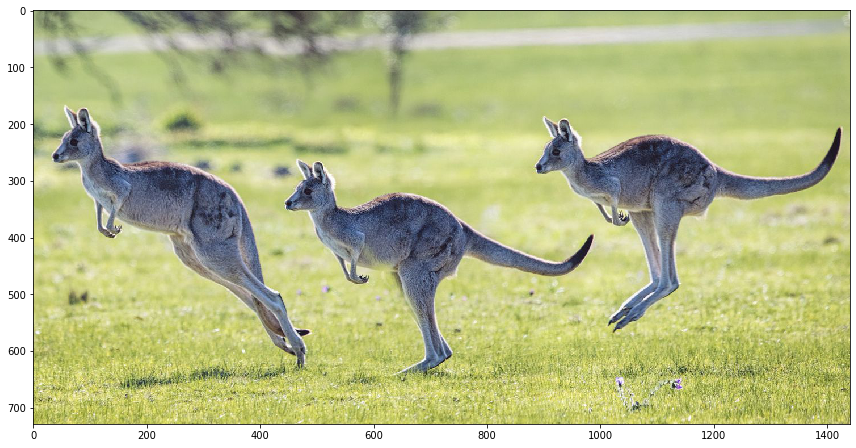

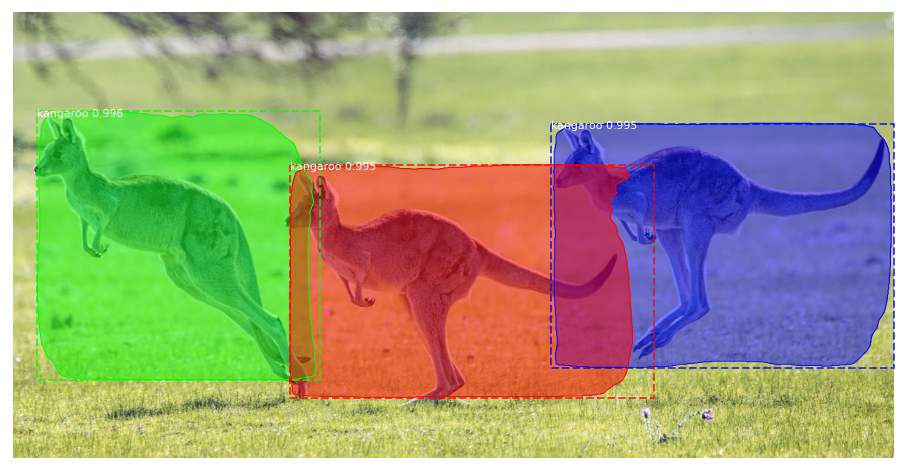

In [34]:
#evaluate the mask-rcnn model on the kangaroo dataset
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import mrcnn.model as modellib
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model 
import skimage.io


#class that defines and loads the kangaroo dataset
class KanagarooDataset(Dataset):
  #load dataset definitions
  def load_dataset(self, dataset_dir, is_train= True):
    #define classes
    self.add_class('dataset', 1, 'kangaroo')
    #define data locations
    images_dir= dataset_dir + 'images/'
    annotations_dir= dataset_dir + 'annots/'
    #find all images
    for filename in listdir(images_dir):
      #extract image id
      image_id= filename[:-4]
      #skip bad images
      if image_id in ['00090']:
        continue
      #skip all images after 150 for train set
      if is_train and int(image_id) >=150:
        continue
      #skip all images before 150 for testing set
      if not is_train and int(image_id) < 150:
        continue
      img_path= images_dir + filename
      ann_path= annotations_dir + image_id + '.xml'
      #add to dataset
      self.add_image('dataset', image_id= image_id, path= image_path, annotation= ann_path)

  ##extract bounding boxes from annotation file
  def extract_boxes(self, filename):
    #load and parse the file
    tree= ElementTree.parse(filename)
    #get the root of the document
    root= tree.getroot()
    #extract each bounsing box
    boxes= list()
    for box in root.findall('.//bndbox'):
      xmin= int(box.find('xmin').text)
      ymin= int(box.find('ymin').text)
      xmax= int(box.find('xmax').text)
      ymax= int(box.find('ymax').text)
      coors= [xmin, ymin, xmax, ymax]
      boxes.append(coors)
    #extract image dimensions
    width= int(root.find('.//size/width').text)
    height= int(root.find('.//size/height').text)
    return boxes, width, height

  #load the mask for an image
  def load_mask(self, image_id):
    #get details of the image
    info= self.image_info[image_id]
    #define box file locations
    path= info['annotation']
    #load xml
    boxes, w, h= self.extract_boxes(path)
    #create one array for all masks, each ona different channel
    masks= zeros([h, w, len(boxes)], dtype= 'uint8')
    #create masks
    for i  in range(len(boxes)):
      box= boxes()
      row_s, row_e= box[1], box[3]
      col_s, col_e= box[0], box[2]
      masks[row_s:row_e, col_s, col_e, i]= 1
      class_ids.append(self.class_names.index('kangaroo'))
    return masks, asarray(class_ids, dtype= 'int32')

  #load an image reference
  def image_reference(self, image_id):
    info= self.image_info[image_id]
    return info['path']

#define the prediction configuration
class PredictionConfig(Config):
  #define the name of the configuration
  NAME= 'kangaroo_cfg'
  #number of classes (including the background)
  NUM_CLASSES= 1 + 1
  #simplify gpu config
  GPU_COUNT= 1
  IMAGES_PER_GPU= 1

#calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
  APs= list()
  for image_id in dataset.image_ids:
    #load image, bounding boxes and masks for the image id
    image, _, gt_class_id, gt_bbox, gt_mask= load_image_gt(dataset, cfg,
                                                           image_id, use_mini_mask= False)
    #convert pixel values (ex. center)
    scaled_image= mold_image(image, cfg)
    #convert image into one sample
    sample= expand_dims(scaled_image, 0)
    #make prediction
    yhat= model.detect(sample, verbose= 0)
    #extract results for first sample
    r= yhat[0]
    #calculate statistics including AP
    AP, _, _, _= compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'],
                           r['scores'], r['masks'])
    #store
    APs.append(AP)
  #calculate the mean AP across all images
  mAP= mean(APs)
  return mAP

#load the train dataset
train_set= KangarooDataset()
train_set.load_dataset('/content/kangaroo/', is_train= True)
train_set.prepare()
print('Train= %d' % len(train_set.image_ids))
#load test dataset
test_set= KangarooDataset()
test_set.load_dataset('/content/kangaroo/', is_train= False)
test_set.prepare()
print('Test= %d' % len(test_set.image_ids))
#create config
cfg= PredictionConfig()
#define the model
model= modellib.MaskRCNN(mode= 'inference', model_dir= './', config= cfg)
#load trained model weights
model.load_weights('/content/logs/kangaroo_cfg20200428T1850/mask_rcnn_kangaroo_cfg_0005.h5', by_name=True)
#evaluate model on training dataset
train_mAP= evaluate_model(train_set, model, cfg)
print('Train mAP: %.3f' % train_mAP)
#evaluate model on test dataset
test_mAP= evaluate_model(test_set, model, cfg)
print('Test mAP: %.3f' % test_mAP)
------
class_names= ['kangaroo']
#load image 
image= skimage.io.imread('/content/kangaroos0.jpg')
#original image
plt.figure(figsize=(12,10))
skimage.io.imshow(image)
#make predictions
results= model.detect([image], verbose= 1)
#visualize results
r= results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], test_set.class_names, r['scores'])

#Run Detection

#Save Mask-MCRNN Model
This step in the process can be very tricky.
Once the trained, updated model has been trained on the new dataset, it's time to save the model to make predictions on new images it has never seen.